# GAN implementation

## Data generation and preprocessing

In [163]:
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# import classical libraries
%matplotlib inline
%pylab inline

# avoid warnings
import warnings
warnings.filterwarnings("ignore")

# figure size
rcParams['figure.figsize'] = (16, 9)

# print only 2 decimals
set_printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [4]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
time = arange(0.01, T, dt)

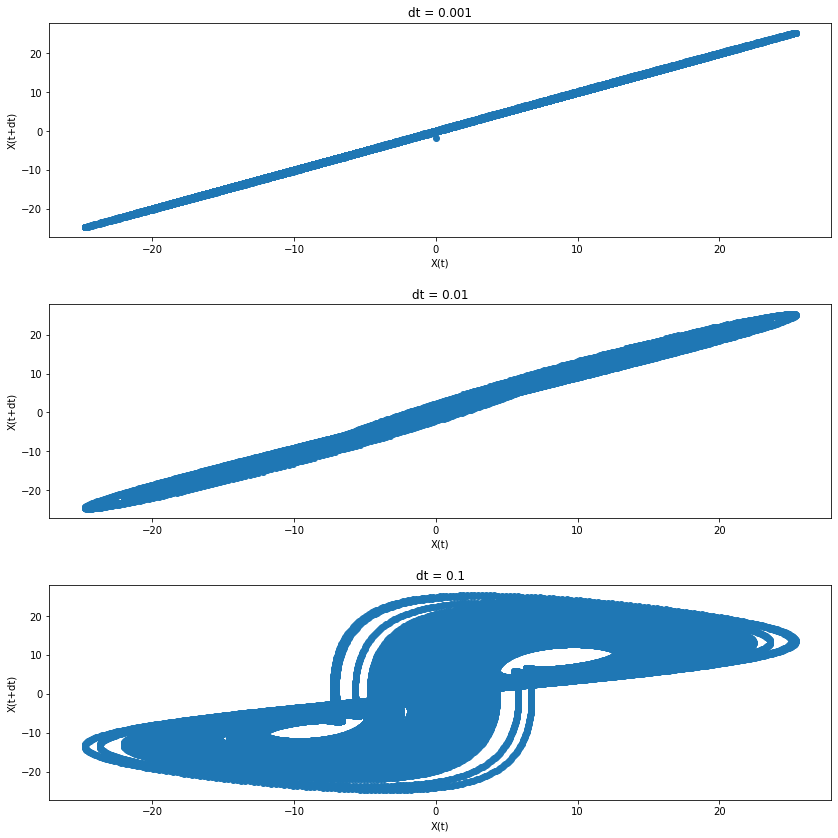

In [7]:
dt_vec = [0.001, 0.01, 0.1]

i = 1

x_ = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))

fig = plt.figure(figsize=(12,12))

for dt in dt_vec:
    
    xtplus = deque(x[:,1])
    xtplus.rotate(int(dt/dt_vec[0]))

    xtplus = np.array(list(xtplus))
    np.shape(xtplus)
    
    subplot(3,1,i)
    plt.scatter(x[:,1],xtplus)
    plt.title('dt = '+str(dt))
    plt.xlabel('X(t)')
    plt.ylabel('X(t+dt)')
    i += 1
    
fig.tight_layout(pad = 2)

In [117]:
def generate_data(N,l):
    
    #Model parameters
    dt = 0.001 # integration time step
    sigma = 10
    rho = 28
    beta = 8/3
    #l = int((T-dt)/dt)
    T = dt*(l+1)

    X = np.zeros((N,3*l))
    
    for n in range(N):    

        x0 = [np.random.randn(), np.random.randn(), np.random.randn()]

        # generate the Lorenz-63 system
        x = odeint(Lorenz_63, x0, arange(dt,T,dt), args=(sigma, rho, beta))
        X[n,...] = np.ndarray.flatten(x)
    return X

In [167]:
N = 1000
X = generate_data(N,100)

X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)

## Create model

In [19]:
import keras
from keras.layers import Dense, Dropout, Input, Conv2D
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.optimizers import Adam

In [256]:
class gan(object): 
    def __init__(self):
        self.generator = Sequential() 
        self.discriminator = Sequential()
        self.gan = Model()
        
        self.create_generator()
        self.create_discriminator()
        self.create_gan()
    
    def create_generator(self):
        
        self.generator.add(Dense(units=256,input_dim=300, activation='selu'))

        self.generator.add(Dense(units=256, activation='selu'))

        self.generator.add(Dense(units=256, activation='selu'))

        self.generator.add(Dense(units=300, activation='selu'))

        self.generator.compile(loss='mean_squared_error', optimizer='adam')
        
    def create_discriminator(self):
        
        self.discriminator.add(Dense(units=256,input_dim=300, activation='selu'))

        self.discriminator.add(Dense(units=256, activation='selu'))

        self.discriminator.add(Dense(units=256, activation='selu'))

        self.discriminator.add(Dense(units=1, activation='sigmoid'))

        self.discriminator.compile(loss='binary_crossentropy', optimizer='adam')

    def create_gan(self):
        
        self.discriminator.trainable=False
        gan_input = Input(shape=(300,))
        x = self.generator(gan_input)
        gan_output= self.discriminator(x)
        self.gan = Model(inputs=gan_input, outputs=gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer='adam')
    
    def gan_summary(self):
        
        self.gan.summary()
        
    def generator_summary(self):
        
        self.generator.summary()

    def discriminator_summary(self):
        
        self.discriminator.summary()
        
    def train(self,X_train, epochs=1, batch_size=128):

        #Loading the data
        batch_count = int((X_train.shape[0] / batch_size))+1

        loss_list = []
        for e in range(1,epochs+1 ):
            print("Epoch %d" %e)
            loss = 0

            idx = np.random.randint(0,X_train.shape[0],X_train.shape[0])

            for _ in tqdm(range(batch_count)):

                # Real trajectories
                real_trajectory = X_train[idx[batch_size*_:batch_size*_+batch_size,...]]

                N = np.shape(real_trajectory)[0]#we now use N instead of batch_size, as the last batch
                                                #may be smaller than the batch size

                #generate  random noise as an input  to  initialize the  generator
                noise= np.random.normal(0,1, [N, 300])

                generated_trajectory = self.generator.predict(noise)#.reshape(N,100,3)

                #Construct different batches of  real and fake data 
                X= np.concatenate([real_trajectory, generated_trajectory], axis=0)

                # Labels for generated and real data
                y_dis=np.zeros(2*N)
                y_dis[:N]= 1 #0.9bat

                #Pre train discriminator on  fake and real data  before starting the gan. 
                self.discriminator.trainable=True
                self.discriminator.train_on_batch(X, y_dis)

                #Tricking the noised input of the Generator as real data
                noise= np.random.normal(0,1, [N, 300])
                y_gen = np.ones(N)

                # During the training of gan, 
                # the weights of discriminator should be fixed. 
                #We can enforce that by setting the trainable flag
                self.discriminator.trainable=False

                #training  the GAN by alternating the training of the Discriminator 
                #and training the chained GAN model with Discriminator’s weights freezed.
                loss = loss + self.gan.train_on_batch(noise, y_gen)
            loss_list.append(loss)
        return loss_list
            #if e == 1 or e % 20 == 0:

                 #plot_generated_images(e, generator)
            
    def generate(self,N):

        noise= np.random.normal(0,1, [N, 300])

        return np.transpose(self.generator.predict(noise))
        

In [257]:
g=gan()
g.generator_summary()
g.discriminator_summary()
g.gan_summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_491 (Dense)            (None, 256)               77056     
_________________________________________________________________
dense_492 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_493 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_494 (Dense)            (None, 300)               77100     
Total params: 285,740
Trainable params: 285,740
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_495 (Dense)            (None, 256)               77056     
_________________________________________________________________
dens

## Train model

In [ ]:
loss = g.train(X_train,10)





  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1


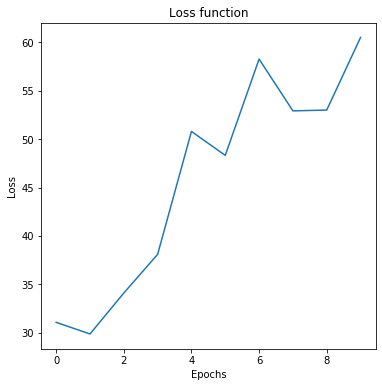

In [236]:
plt.figure(figsize=(6,6))
plt.plot(loss)
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluation

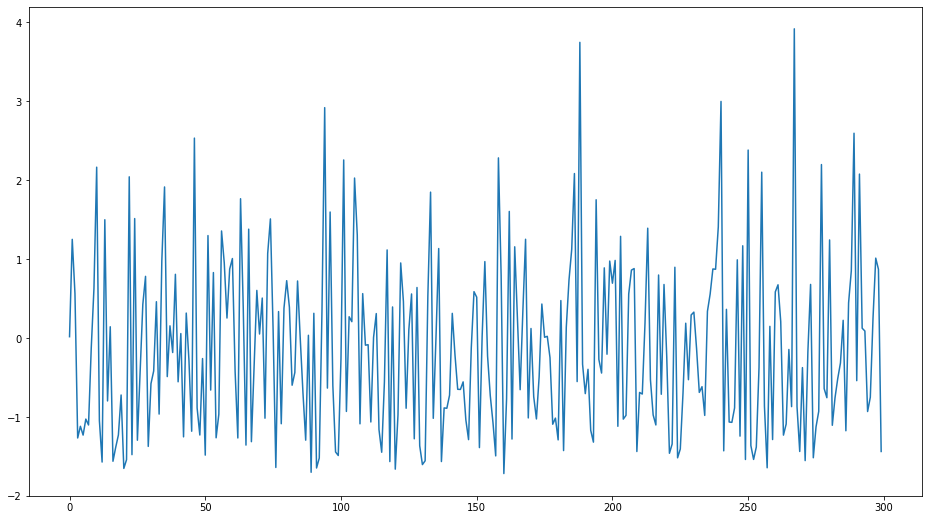

In [255]:
generated_data = g.generate(1)
plt.plot(generated_data)
plt.show()